In [ ]:
!pip install shapely

In [1]:
import pandas as pd

# Load the datasets
known_routes_path = r"/content/final_known_route_repo.csv"
ongoing_trips_path = r"/content/final_on_going_trip_data.csv"

# Read the CSV files
df_known_routes = pd.read_csv(known_routes_path)
df_ongoing_trips = pd.read_csv(ongoing_trips_path)

# Display basic info about the datasets
df_known_routes.info(), df_ongoing_trips.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3541 entries, 0 to 3540
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      3541 non-null   int64  
 1   Route_ID        3541 non-null   object 
 2   latitude        3541 non-null   float64
 3   longitude       3541 non-null   float64
 4   Route_Type      3541 non-null   int64  
 5   Start_Location  3541 non-null   object 
 6   Goal_Location   3541 non-null   object 
 7   Date            3541 non-null   object 
 8   Time            3541 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 249.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851 entries, 0 to 850
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  851 non-null    int64  
 1   Pallet_ID   851 non-null    object 
 2   latitude    851 non-null    float64
 3   longitude   851 non-n

(None, None)

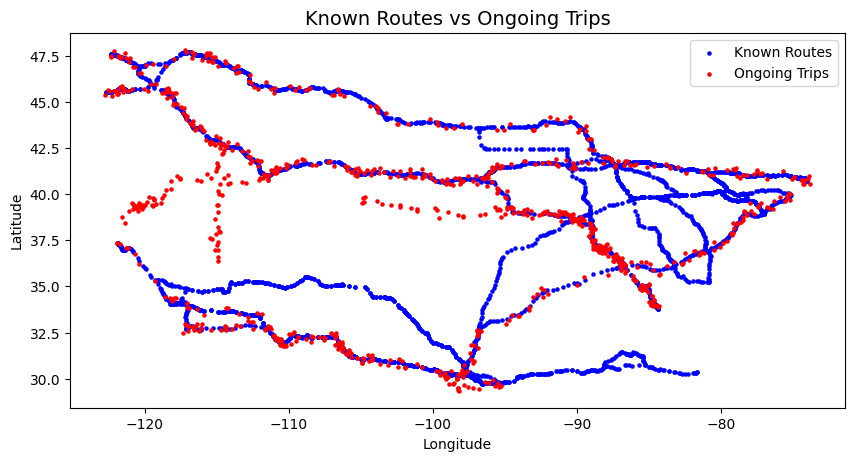

In [2]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Create GeoDataFrames
gdf_known_routes = gpd.GeoDataFrame(
    df_known_routes, geometry=gpd.points_from_xy(df_known_routes.longitude, df_known_routes.latitude), crs="EPSG:4326"
)

gdf_ongoing_trips = gpd.GeoDataFrame(
    df_ongoing_trips, geometry=gpd.points_from_xy(df_ongoing_trips.longitude, df_ongoing_trips.latitude), crs="EPSG:4326"
)

# Plot the routes
fig, ax = plt.subplots(figsize=(10, 6))
gdf_known_routes.plot(ax=ax, markersize=5, color="blue", label="Known Routes")
gdf_ongoing_trips.plot(ax=ax, markersize=5, color="red", label="Ongoing Trips")

# Add legend and labels
ax.set_title("Known Routes vs Ongoing Trips", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.show()

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import zscore

In [4]:
# Convert Latitude and Longitude into numpy arrays
ongoing_coords = np.array(list(zip(df_ongoing_trips.latitude, df_ongoing_trips.longitude)))
known_coords = np.array(list(zip(df_known_routes.latitude, df_known_routes.longitude)))


In [5]:
### 1️⃣ DBSCAN - Tuned Parameters ###
dbscan = DBSCAN(eps=0.05, min_samples=10).fit(known_coords)
df_ongoing_trips["DBSCAN_Anomaly"] = dbscan.fit_predict(ongoing_coords)

### 2️⃣ LOF - Local Outlier Factor (Lower contamination) ###
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_labels = lof.fit_predict(ongoing_coords)
df_ongoing_trips["LOF_Anomaly"] = lof_labels

### 3️⃣ Z-Score Based Anomaly Detection (Relaxed Threshold) ###
df_ongoing_trips["lat_zscore"] = zscore(df_ongoing_trips["latitude"])
df_ongoing_trips["long_zscore"] = zscore(df_ongoing_trips["longitude"])
df_ongoing_trips["Z_Score_Anomaly"] = ((df_ongoing_trips["lat_zscore"].abs() > 3.5) | (df_ongoing_trips["long_zscore"].abs() > 3.5)).astype(int)

### 4️⃣ IQR - Interquartile Range Outlier Detection (Relaxed) ###
Q1_lat, Q3_lat = df_ongoing_trips["latitude"].quantile([0.25, 0.75])
IQR_lat = Q3_lat - Q1_lat
Q1_long, Q3_long = df_ongoing_trips["longitude"].quantile([0.25, 0.75])
IQR_long = Q3_long - Q1_long

df_ongoing_trips["IQR_Anomaly"] = ((df_ongoing_trips["latitude"] < (Q1_lat - 2 * IQR_lat)) |
                                    (df_ongoing_trips["latitude"] > (Q3_lat + 2 * IQR_lat)) |
                                    (df_ongoing_trips["longitude"] < (Q1_long - 2 * IQR_long)) |
                                    (df_ongoing_trips["longitude"] > (Q3_long + 2 * IQR_long))).astype(int)

### 5️⃣ Combine Anomaly Detection Methods ###
df_ongoing_trips["Final_Anomaly"] = ((df_ongoing_trips["DBSCAN_Anomaly"] == -1) |
                                      (df_ongoing_trips["LOF_Anomaly"] == -1) |
                                      (df_ongoing_trips["Z_Score_Anomaly"] == 1) |
                                      (df_ongoing_trips["IQR_Anomaly"] == 1)).astype(int)

### 🔥 Filter Only Anomalous Data ###
anomalous_points = df_ongoing_trips[df_ongoing_trips["Final_Anomaly"] == 1]

# Save the anomalies for further use
anomalous_points.to_csv("detected_anomalies1.csv", index=False)

In [ ]:
df1.describe()

,Unnamed: 0,latitude,longitude,DBSCAN_Anomaly,LOF_Anomaly,lat_zscore,long_zscore,Z_Score_Anomaly,IQR_Anomaly,Final_Anomaly
count,851.000000,851.000000,851.000000,851.0,851.000000,8.510000e+02,8.510000e+02,851.0,851.0,851.0
mean,425.000000,38.819794,-101.198493,-1.0,0.898942,-5.009702e-16,6.011642e-16,0.0,0.0,1.0
std,245.806835,4.701582,13.412755,0.0,0.438324,1.000588e+00,1.000588e+00,0.0,0.0,0.0
min,0.000000,29.347469,-122.737772,-1.0,-1.000000,-2.015895e+00,-1.606825e+00,0.0,0.0,1.0
25%,212.500000,35.097508,-114.265247,-1.0,1.000000,-7.921750e-01,-9.747765e-01,0.0,0.0,1.0
50%,425.000000,39.357311,-101.074409,-1.0,1.000000,1.143940e-01,9.256607e-03,0.0,0.0,1.0
75%,637.500000,41.619778,-89.627951,-1.0,1.000000,5.958910e-01,8.631595e-01,0.0,0.0,1.0
max,850.000000,47.834268,-73.845570,-1.0,1.000000,1.918455e+00,2.040521e+00,0.0,0.0,1.0


## DBSCAN and Z-score

In [7]:
# 1️⃣ DBSCAN - Density-Based Outlier Detection
dbscan = DBSCAN(eps=0.05, min_samples=10).fit(known_coords)
df_ongoing_trips["DBSCAN_Anomaly"] = dbscan.fit_predict(ongoing_coords)

# 2️⃣ LOF - Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_labels = lof.fit_predict(ongoing_coords)
df_ongoing_trips["LOF_Anomaly"] = lof_labels

# 3️⃣ Z-Score Based Anomaly Detection
df_ongoing_trips["lat_zscore"] = zscore(df_ongoing_trips["latitude"])
df_ongoing_trips["long_zscore"] = zscore(df_ongoing_trips["longitude"])
df_ongoing_trips["Z_Score_Anomaly"] = ((df_ongoing_trips["lat_zscore"].abs() > 3.5) | (df_ongoing_trips["long_zscore"].abs() > 3.5)).astype(int)

# 4️⃣ IQR - Interquartile Range Outlier Detection
Q1_lat, Q3_lat = df_ongoing_trips["latitude"].quantile([0.25, 0.75])
IQR_lat = Q3_lat - Q1_lat
Q1_long, Q3_long = df_ongoing_trips["longitude"].quantile([0.25, 0.75])
IQR_long = Q3_long - Q1_long

df_ongoing_trips["IQR_Anomaly"] = ((df_ongoing_trips["latitude"] < (Q1_lat - 2 * IQR_lat)) |
                                   (df_ongoing_trips["latitude"] > (Q3_lat + 2 * IQR_lat)) |
                                   (df_ongoing_trips["longitude"] < (Q1_long - 2 * IQR_long)) |
                                   (df_ongoing_trips["longitude"] > (Q3_long + 2 * IQR_long))).astype(int)

# 5️⃣ Combine Anomaly Detection Methods
df_ongoing_trips["Final_Anomaly"] = ((df_ongoing_trips["DBSCAN_Anomaly"] == -1) |
                                     (df_ongoing_trips["LOF_Anomaly"] == -1) |
                                     (df_ongoing_trips["Z_Score_Anomaly"] == 1) |
                                     (df_ongoing_trips["IQR_Anomaly"] == 1)).astype(int)

# 🔥 Filter Only Anomalous Data
anomalous_points = df_ongoing_trips[df_ongoing_trips["Final_Anomaly"] == 1]

# Save the anomalies for further use
anomalous_points.to_csv("detected_anomalies2.csv", index=False)

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
# Normalize data
scaler = MinMaxScaler()
df_known_routes[['latitude', 'longitude']] = scaler.fit_transform(df_known_routes[['latitude', 'longitude']])
df_ongoing_trips[['latitude', 'longitude']] = scaler.transform(df_ongoing_trips[['latitude', 'longitude']])

# Create fixed-size sequences
def create_sequences(data, seq_length=10):
    sequences = []
    for i in range(len(data) - seq_length + 1):
        seq = data.iloc[i:i + seq_length].values
        sequences.append(seq)
    return np.array(sequences)

In [10]:
sequence_length = 10
X_train = create_sequences(df_known_routes[['latitude', 'longitude']], sequence_length)
X_test = create_sequences(df_ongoing_trips[['latitude', 'longitude']], sequence_length)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(len(X_train), sequence_length, 2)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(len(X_test), sequence_length, 2)

## AUTOENCODER

In [11]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=16):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
# Initialize Model
model = Autoencoder(input_dim=2, encoding_dim=16)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()  # Ensure the model is in training mode

    optimizer.zero_grad()
    outputs = model(X_train_tensor)  # Forward pass

    loss = criterion(outputs, X_train_tensor)  # Compute reconstruction loss

    loss.backward()  # Backpropagation
    optimizer.step()  # Optimize model weights

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}")


Epoch [0/50], Loss: 0.086105
Epoch [10/50], Loss: 0.083275
Epoch [20/50], Loss: 0.081725
Epoch [30/50], Loss: 0.080495
Epoch [40/50], Loss: 0.078967


In [ ]:
# Set anomaly threshold (95th percentile)
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

# Extract anomaly data
df_anomalies = df_ongoing_trips.iloc[:len(anomalies)][anomalies]
df_anomalies.to_csv("detected_anomalies5.csv", index=False)

print("🚨 Route Deviations Detected! Check detected_anomalies.csv for results.")

🚨 Route Deviations Detected! Check detected_anomalies.csv for results.


##  DQN + RL

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import networkx as nx

# Step 1: Load and Process Data
import pandas as pd
known_routes_df = pd.read_csv("/mnt/data/final_known_route_repo.csv")
ongoing_trips_df = pd.read_csv("/mnt/data/final_on_going_trip_data - Copy.csv")

# Step 2: Create Logistics Network Graph
G = nx.Graph()
nodes = known_routes_df["Start_Location"].tolist() + known_routes_df["Goal_Location"].tolist()
edges = list(zip(known_routes_df["Start_Location"], known_routes_df["Goal_Location"]))
G.add_edges_from(edges)

# Step 3: Define Reinforcement Learning Components
class DQN(nn.Module):
    def _init_(self, state_dim, action_dim):
        super(DQN, self)._init_()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Define Environment
class LogisticsEnv:
    def _init_(self, graph):
        self.graph = graph
        self.locations = list(graph.nodes)
        self.state_size = len(self.locations)
        self.action_size = len(self.locations)
        self.current_location = random.choice(self.locations)
        self.goal_location = random.choice(self.locations)
    
    def reset(self):
        self.current_location = random.choice(self.locations)
        self.goal_location = random.choice(self.locations)
        return torch.tensor([self.locations.index(self.current_location)], dtype=torch.float32).unsqueeze(0)
    
    def step(self, action):
        next_location = self.locations[action]
        if self.graph.has_edge(self.current_location, next_location):
            self.current_location = next_location
            reward = -1  # Small penalty for each move
            if self.current_location == self.goal_location:
                reward = 100  # Reward for reaching destination
            return torch.tensor([self.locations.index(self.current_location)], dtype=torch.float32).unsqueeze(0), reward, self.current_location == self.goal_location
        else:
            return torch.tensor([self.locations.index(self.current_location)], dtype=torch.float32).unsqueeze(0), -10, False  # Large penalty for invalid moves

# Step 4: Train Deep Q-Network
env = LogisticsEnv(G)
dqn = DQN(env.state_size, env.action_size)
optimizer = optim.Adam(dqn.parameters(), lr=0.001)
criterion = nn.MSELoss()

epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
gamma = 0.9

for episode in range(1000):
    state = env.reset()
    done = False
    while not done:
        if random.random() < epsilon:
            action = random.randint(0, env.action_size - 1)  # Explore
        else:
            with torch.no_grad():
                action = torch.argmax(dqn(state)).item()  # Exploit
        
        next_state, reward, done = env.step(action)
        target = reward + gamma * torch.max(dqn(next_state)).item()
        
        output = dqn(state)[0, action]
        loss = criterion(output, torch.tensor(target, dtype=torch.float32).unsqueeze(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        state = next_state
    
    epsilon = max(epsilon * epsilon_decay, epsilon_min)
    if episode % 100 == 0:
        print(f"Episode {episode}, Epsilon: {epsilon:.2f}, Loss: {loss.item():.4f}")

# Step 5: Deploy for Real-Time Monitoring
print("DQN Model Trained for Dynamic Route Optimization")